<a href="https://colab.research.google.com/github/nuriaprol/PFG/blob/main/CodigoPFG_6_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerías

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_curve, auc, confusion_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import date

from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px

!pip install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from prophet import Prophet

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#Carga de datos


##Carga de BRP y Generadoras


In [ ]:
datosBRP = pd.read_csv('datosBRP (1).csv', delimiter=';', decimal=',')



#Pasamos a numérico las columnas necesarias para hacer el análisis
datosBRP['cargo de regulación'] = pd.to_numeric(datosBRP['cargo de regulación'], errors='coerce')
datosBRP["desviacion por defecto"] = pd.to_numeric(datosBRP["desviacion por defecto"], errors="coerce")
datosBRP["desviacion por exceso"] = pd.to_numeric(datosBRP["desviacion por exceso"], errors="coerce")

#Desviación total es la suma de ambas desviaciones
datosBRP["desviacion total"] = datosBRP["desviacion por defecto"] + datosBRP["desviacion por exceso"]
print(datosBRP[["desviacion por defecto", "desviacion por exceso", "desviacion total"]].head())

datosBRP = datosBRP.dropna()
datosBRP.head()

In [ ]:
datos_generacion = pd.read_csv("Breakdown of Production_20240314_20250314.csv", sep=';', skiprows=1, header=1, encoding='utf-8')

datos_generacion = datos_generacion.dropna()
datos_generacion.head()

In [ ]:
datosBRP.info()

In [ ]:
datos_generacion.info()

##Unión BBDD


Se van a unir las bases de datos para poder trabajar con solo una variables. Primero es necesario pasar la base de datos de generación de cuartohoraria a horaria. Al tratarse de potencia (MW) los valores no se deben sumar si no calcular la potencia media de esa hora.

In [ ]:
#Obtener mismo formato que la base de datos DatosBRP
datos_generacion["Date and Time"] = pd.to_datetime(datos_generacion["Date and Time"])

#Se extraen la fecha y la hora
datos_generacion["Fecha_Prev"] = datos_generacion["Date and Time"].dt.date
datos_generacion["Hora"] = datos_generacion["Date and Time"].dt.hour + 1 #La hora 1 corresponde de 00:00 a 00:59
datos_generacion["Fecha_Prev"] = pd.to_datetime(datos_generacion["Fecha_Prev"]).dt.strftime("%-d/%-m/%Y")

#Se agrupan por fecha y hora para pasar de formato cuartohorario a horario
#Se hace la media porque están en MW y no en MWh, por lo que así obtenemos la potencia media por hora.
datos_generacion = datos_generacion.groupby(["Fecha_Prev", "Hora"]).mean(numeric_only=True).reset_index()

# Eliminar columna original
if "Date and Time" in datos_generacion.columns:
    datos_generacion = datos_generacion.drop(columns=["Date and Time"])

# Convertir de string a datetime, asumiendo que el formato original es día/mes/año
datos_generacion["Fecha_Prev"] = pd.to_datetime(datos_generacion["Fecha_Prev"], dayfirst=True)

# Luego convertir a string en formato 14/03/2024
datos_generacion["Fecha_Prev"] = datos_generacion["Fecha_Prev"].dt.strftime("%d/%m/%Y")

Buscamos obtener 8784 registros porque estamos trabajando del 14/03/2024 al 14/03/2025, son 365 días más 1 más por estar el 14 dos veces.
Entonces 24h x 366d = 8784 registros

In [ ]:
len(datos_generacion)

In [ ]:
len(datosBRP)

Hay un dato faltante en datos generación, probamos a ver si es la hora 2 del 31 de marzo de 2024, que fue cuando se realizo el cambio horario de verano, donde se pasó de la 1am directamente a las 3am

In [ ]:
# Buscar el dato del 31/03/2024 y hora 2 (Cambia de hora verano)
dato_buscado = datos_generacion[(datos_generacion["Fecha_Prev"] == pd.to_datetime("2024-03-31").date()) &
                           (datos_generacion["Hora"] == 2)]

dato_buscado

Pata completar este dato y tener los mismos registros en ambas bases de datos, se completará la hora 2 faltante con la media de la hora 1 y la hora 3.

In [ ]:
# Filtrar horas 1 y 3 del 31 de marzo de 2024
h1 = datos_generacion[(datos_generacion["Fecha_Prev"] == "31/03/2024") & (datos_generacion["Hora"] == 1)]
h3 = datos_generacion[(datos_generacion["Fecha_Prev"] == "31/03/2024") & (datos_generacion["Hora"] == 3)]

#Calcular la media entre las dos filas (sin tocar Fecha_Prev ni Hora)
media_valores = (h1.iloc[0, 2:] + h3.iloc[0, 2:]) / 2

# Crear nueva fila copiando de una de las existentes
nueva_fila = h1.copy()
nueva_fila["Hora"] = 2
nueva_fila.iloc[0, 2:] = media_valores

# Añadir al DataFrame original
datos_generacion = pd.concat([datos_generacion, nueva_fila], ignore_index=True)

# Reordenar por fecha y hora
datos_generacion = datos_generacion.sort_values(by=["Fecha_Prev", "Hora"]).reset_index(drop=True)
len(datos_generacion)


Como se había tomado en cuenta el cambio de hora de veano buscamos también ek de invierno, donde a las 3:00 de la madrugada, los relojes se atrasaron una hora, volviendo a marcar las 2:00. Ocasionando así la hora 25 de ese día

In [ ]:
dato_buscado = datosBRP[(datosBRP["Fecha_Prev"] == "27/10/2024")]
#& (datosBRP["Hora"] == 25)]
dato_buscado

In [ ]:
datosBRP = datosBRP[~((datosBRP["Fecha_Prev"] =="27/10/2024") & (datosBRP["Hora"] == 25))]

In [ ]:
# Filtrar las filas de interés
h1 = datosBRP[(datosBRP["Fecha_Prev"] == "31/03/2024") & (datosBRP["Hora"] == 23)]
h3 = datosBRP[(datosBRP["Fecha_Prev"] == "01/04/2024") & (datosBRP["Hora"] == 1)]

if not h1.empty and not h3.empty:
    # Convertir columnas numéricas para el cálculo
    vals1 = pd.to_numeric(h1.iloc[0, 2:], errors='coerce')
    vals2 = pd.to_numeric(h3.iloc[0, 2:], errors='coerce')
    media_valores = (vals1 + vals2) / 2

    # Crear la nueva fila con la media
    nueva_fila = h1.copy()
    nueva_fila["Hora"] = 24
    nueva_fila.iloc[0, 2:] = media_valores

    # Añadir al DataFrame original
    datosBRP = pd.concat([datosBRP, nueva_fila], ignore_index=True)
    datosBRP = datosBRP.sort_values(by=["Fecha_Prev", "Hora"]).reset_index(drop=True)
    print("Fila interpolada agregada correctamente.")
else:
    print("No se encontraron ambas filas necesarias para interpolar.")


In [ ]:
len(datos_generacion), len(datosBRP)

In [ ]:
# Corregir formato inconsistente en datosBRP
datosBRP["Fecha_Prev"] = pd.to_datetime(datosBRP["Fecha_Prev"], format="mixed", dayfirst=True).dt.strftime("%d/%m/%Y")
datos_generacion["Fecha_Prev"] = pd.to_datetime(datos_generacion["Fecha_Prev"], format="mixed", dayfirst=True).dt.strftime("%d/%m/%Y")


# Hacer el merge
df_unido = datosBRP.merge(datos_generacion, on=["Fecha_Prev", "Hora"], how="inner")
print(len(df_unido))


In [ ]:
df_unido.head()

In [ ]:
# Conjuntos de claves (fecha, hora)
claves_brp = set(zip(datosBRP["Fecha_Prev"], datosBRP["Hora"]))
claves_generacion = set(zip(datos_generacion["Fecha_Prev"], datos_generacion["Hora"]))
claves_unidas = set(zip(df_unido["Fecha_Prev"], df_unido["Hora"]))
claves_perdidas = claves_brp - claves_unidas
print(f"🔍 Total de filas perdidas en el merge: {len(claves_perdidas)}")

# Filas de datosBRP que no están en el df_unido
perdidas_df = datosBRP[datosBRP[["Fecha_Prev", "Hora"]].apply(tuple, axis=1).isin(claves_perdidas)]
perdidas_df.head()


Vamos a hacer ahora la suma total de todas las columnas para ver si hay alguna columna que no tenga valores y eliminarla.

In [ ]:
try:
    resumen_sumas = df_unido.select_dtypes(include='number').sum().to_frame(name="Suma_total")
except NameError:
    resumen_sumas = pd.DataFrame({"Error": ["df_unido no está definido. Ejecuta el merge primero."]})

print(resumen_sumas)

Tanto wave como coal tiene potencia 0 durante todo el año por lo que no son relevantes y las eliminamos.

In [ ]:
df_unido = df_unido.drop(columns=["Wave", "Coal"], errors="ignore")

#ANÁLISIS EXPLORATORIO


##Distribuciones

Para comenzar con el análisis exploratorio de los datos disponibles, se procede al estudio de las distribuciones empíricas de cinco variables clave dentro del sistema eléctrico: "pool" (precio del mercado mayorista), "conteo" (energía programada), "posición final" (energía realmente consumida), "desviación total" (diferencia entre lo programado y lo consumido), y "cargo de regulación" (coste imputado por la activación de reservas del sistema).

Este análisis tiene como objetivo identificar el comportamiento estadístico de cada variable, detectar la presencia de valores extremos (outliers) y comprender las posibles relaciones entre ellas. A través de representaciones gráficas como histogramas y diagramas de caja (boxplots), se observará el grado de simetría,  y sesgo de las distribuciones.

En particular, la variable "cargo de regulación" será objeto de especial atención, ya que representa la variable objetivo del análisis. Su alta variabilidad y la presencia de valores atípicos negativos requieren un tratamiento estadístico cuidadoso para no distorsionar los modelos y obtener interpretaciones robustas sobre los factores que inciden en su evolución.





In [ ]:
# Lista de variables a analizar
variables_a_estudiar = [
    "pool",
    "conteo",
    "posicion final",
    "desviacion total",
    "cargo de regulación"
]

# Histograma + curva de densidad con seaborn
for var in variables_a_estudiar:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_unido[var], kde=True, bins=50, color="skyblue")
    plt.title(f"Distribución de la variable: {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


El precio del pool presenta una distribución asimétrica hacia la derecha, con valores bajos predominantes y picos puntuales que superan los 200 €/MWh, típicos de tensiones entre oferta y demanda.
La variable conteo muestra una distribución estable y moderadamente dispersa, mientras que la posición final presenta mayor variabilidad, lo que indica diferencias entre lo programado y lo realmente consumido.
La desviación total sigue una distribución aproximadamente simétrica centrada en cero, coherente con un sistema donde los desvíos tienden a compensarse.
En cambio, el cargo de regulación presenta una distribución fuertemente asimétrica con valores atípicos negativos muy extremos, lo que requiere un tratamiento específico de outliers para evitar distorsiones en el análisis.

##Boxplots y outliers
A partir de los diagramas de caja (boxplots), es posible visualizar con mayor claridad la presencia, cantidad y ubicación de los valores atípicos en las diferentes variables analizadas.

In [ ]:
for var in variables_a_estudiar:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x=datosBRP[var], color="skyblue")
    plt.title(f"Boxplot de la variable: {var}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Dado que estos datos han sido contrastados con otras fuentes y se ha verificado su validez, no se procederá a eliminarlos del análisis.

In [ ]:
# Cálculo de IQR
Q1 = df_unido["cargo de regulación"].quantile(0.25)
Q3 = df_unido["cargo de regulación"].quantile(0.75)
IQR = Q3 - Q1

# Definir umbrales para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar outliers
outliers = df_unido[(df_unido["cargo de regulación"] < limite_inferior) |
                    (df_unido["cargo de regulación"] > limite_superior)]

print(f"Número total de registros: {len(df_unido)}")
print(f"Número de outliers detectados: {len(outliers)}")
print(f"Porcentaje de outliers: {100 * len(outliers) / len(df_unido):.2f}%")

# Mostrar los 10 valores más bajos y más altos
outliers_extremos_ordenados = pd.concat([
    outliers.nsmallest(10, "cargo de regulación"),
    outliers.nlargest(10, "cargo de regulación")
])
print(outliers_extremos_ordenados)


Los registros que se encuentran fuera de estos umbrales fueron clasificados como valores atípicos. Como resultado, se identificaron 414 outliers de un total de 8784 observaciones, lo que equivale aproximadamente al 4.71% del conjunto de datos.

El análisis de los 10 valores extremos del “cargo de regulación” revela que muchos coinciden con festivos, fines de semana o franjas nocturnas de baja generación renovable. Estos factores parecen contribuir a desequilibrios en el sistema, reforzando la hipótesis de que condiciones externas influyen en la aparición de estos picos atípicos.

In [ ]:
df_outliers = df_unido.copy()

# Función para identificar outliers por IQR
def detectar_outliers_iqr(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return (serie < lim_inf) | (serie > lim_sup)

# Aplicar función para cada variable
for var in variables_a_estudiar:
    df_outliers[f"outlier_{var}"] = detectar_outliers_iqr(df_outliers[var])

# Calcular número total de outliers por fila
cols_outliers = [f"outlier_{v}" for v in variables_a_estudiar]
df_outliers["n_outliers"] = df_outliers[cols_outliers].sum(axis=1)

# Filtrar
df_cargo_outliers = df_outliers[df_outliers["outlier_cargo de regulación"] == True]
df_cargo_y_otro = df_cargo_outliers[df_cargo_outliers["n_outliers"] > 1]

# Heatmap
df_heat = df_cargo_y_otro[cols_outliers].head(73)
plt.figure(figsize=(10, 6))
sns.heatmap(df_heat.astype(int), cmap="Blues", cbar=False, linewidths=0.5, linecolor="gray")
plt.title("Registros que son outlier en cargo de regulación y otra(s) variable(s)")
plt.xlabel("Variable")
plt.ylabel("Registro")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Esta representación permite detectar coincidencias relevantes entre outliers multivariables. El análisis muestra que varios registros que presentan valores atípicos en el cargo de regulación también los muestran en desviación total y algunos en la posición final.

In [ ]:
datos_sin_outliers = df_unido[(df_unido["cargo de regulación"] >= limite_inferior) &
                               (df_unido["cargo de regulación"] <= limite_superior)]

#distribución sin outliers
plt.figure(figsize=(10, 4))
sns.histplot(datos_sin_outliers["cargo de regulación"], kde=True, bins=50, color="skyblue")
plt.title("Distribución del cargo de regulación (sin outliers)")
plt.xlabel("cargo de regulación")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


Una vez excluidos dichos outliers, con el fin de entender mejor el comportamiento del resto de los datos se vuelve a graficar la distribución. La distribución presenta una clara asimetría positiva (sesgo a la derecha), concentrando la mayor parte de los valores en torno a los 40-60 euros

## Identificación de patrones diarios o estacionales

In [ ]:
columnas_excluir = ["AÑO", "MES", "Hora"]
df_numerico = df_unido.select_dtypes(include='number').drop(columns=columnas_excluir, errors="ignore")

In [ ]:
result = seasonal_decompose(df_numerico["cargo de regulación"], model="additive", period=24)
result.plot()
plt.show()

Dado que al aplicar la descomposición sobre la serie completa no se apreciaban con claridad los ciclos recurrentes, se optó por trabajar con los primeros 200 registros, lo cual permite aislar mejor los patrones de corta duración, como las fluctuaciones diarias.

In [ ]:
# Se toman los primeros 200 registros
df_numerico_subset = df_numerico.iloc[:200].copy()
df_numerico_subset["cargo de regulación"] = pd.to_numeric(df_numerico_subset["cargo de regulación"], errors='coerce')

# Descomposición estacional
result = seasonal_decompose(df_numerico_subset["cargo de regulación"], model="additive", period=24)

# Visualizar
result.plot()
plt.show()

Dado este resultado, se toma la decisión de agrupar la base de datos por hora con el objetivo de estudiar cómo se relacionan entre sí las diferentes variables a lo largo del ciclo diario. Esta agrupación permite observar el comportamiento promedio de cada variable en función de la hora del día, lo cual resulta especialmente relevante en sistemas energéticos donde la demanda y la generación suelen seguir patrones horarios

##Agrupación por hora
Agrupo por hora pasando de tener miles de datos a únicamente 24 por columna, Calculo la media por hora de todos los datos.



In [ ]:
columnas_excluir = ["AÑO", "MES", "Hora"]
try:
    # Agrupar por hora
    suma_por_hora = df_unido.groupby("Hora").mean(numeric_only=True).reset_index()

    # Ordenar por hora por si acaso
    suma_por_hora = suma_por_hora.sort_values("Hora").reset_index(drop=True)

except NameError:
    suma_por_hora = pd.DataFrame({"Error": ["df_unido no está definido."]})

df_numerico_por_hora = suma_por_hora.select_dtypes(include='number').drop(columns=columnas_excluir, errors="ignore")

In [ ]:
suma_por_hora

##Matriz de correlación

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = df_numerico_por_hora.corr()

# Crear el mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
#Orden de mayor a menor en valor absoluto
correlaciones_charges = correlation_matrix['cargo de regulación'].sort_values(key=lambda x: x.abs(), ascending=False)
correlaciones_charges

Estos resultados son consistentes con las hipótesis iniciales del estudio, que planteaban que tanto el comportamiento del mercado eléctrico (representado por el pool) como la participación de energías renovables tienen una influencia directa en los costes regulatorios. En efecto, tres de las cinco variables más correlacionadas son tecnologías renovables.

##Gráficos para entender posibles relaciones


In [ ]:
# Gráfico 1: Pool y Cargo de Regulación
plt.figure(figsize=(10, 5))
plt.plot(suma_por_hora.index, suma_por_hora["pool"], label="Pool", marker='o')
plt.plot(suma_por_hora.index, suma_por_hora["cargo de regulación"], label="cargo de Regulación", marker='s')
plt.xlabel("Hora")
plt.ylabel("Valor")
plt.title("Pool y Cargo de Regulación por Hora")
plt.legend()
plt.grid(True)
plt.show()


El precio del pool tiende a ser más bajo durante las horas centrales del día (aproximadamente entre las 11:00 y las 17:00), coincidiendo con una mayor penetración de energía solar, mientras que alcanza sus máximos en las horas nocturnas (alrededor de las 21:00). Por el contrario, el cargo de regulación muestra un patrón opuesto, con valores más altos en las horas diurnas y una caída pronunciada al anochecer. Este comportamiento refuerza la correlación negativa detectada entre ambas variables y sugiere que cuando el precio del mercado es bajo, posiblemente debido a una alta generación renovable, se incrementan los desvíos o la necesidad de ajustes, lo que da lugar a mayores costes regulatorios.

In [ ]:
#PORCENTAJES TOTALES POR GENERADORA

excluir = [
    "pool", "desviacion por exceso", "desviacion por defecto",
    "posicion final", "conteo", "cargo de regulación", "AÑO", "MES",
    "Hora", "Consumption", "desviacion total"
]

columnas_tecnologias = [
    col for col in df_unido.select_dtypes(include='number').columns if col not in excluir
]
# Si el dato está cada 15 minutos (0.25h), convierte MW a MWh
factor_tiempo = 1  # Está ya agrupados por hora, entonces dejamos el 1
energia_por_tecnologia = (df_unido[columnas_tecnologias].astype(float) * factor_tiempo).sum()

# Total general
total_general = energia_por_tecnologia.sum()

#porcentajes reales de generación
porcentajes = (energia_por_tecnologia / total_general) * 100

df_porcentajes = porcentajes.reset_index()
df_porcentajes.columns = ['Tecnología', 'Porcentaje (%)']
df_porcentajes = df_porcentajes.sort_values(by='Porcentaje (%)', ascending=False)

print(df_porcentajes)
print(f"Suma total: {df_porcentajes['Porcentaje (%)'].sum():.5f}%")

Aunque el porcentaje total por tecnología generadora permite tener una visión general de la composición del mix energético gestionado por REN, este enfoque resulta limitado para extraer conclusiones precisas. Para comprender realmente la dinámica del sistema y su impacto en variables como el cargo de regulación, es más útil analizar la distribución porcentual por generadora a lo largo del día, ya que permite identificar patrones horarios y posibles correlaciones con eventos específicos del mercado eléctrico.



In [ ]:
#Gráfico 2: Distribución porcentual por tecnología

excluir = [
    "pool", "desviacion por exceso", "desviacion por defecto",
    "posicion final", "conteo", "cargo de regulación", "AÑO", "MES",
    "Hora", "Consumption", "desviacion total"
] #DatosBRP

columnas_tecnologias = [col for col in suma_por_hora.columns if col not in excluir]
df_tecnologias = suma_por_hora[columnas_tecnologias].copy()

totales = df_tecnologias.sum()
umbral = 0.04 * totales.sum() #Se van a agrupar las teconologías por porcentajes menores a 4%
tecnologias_principales = totales[totales >= umbral].index.tolist()
tecnologias_otros = [col for col in df_tecnologias.columns if col not in tecnologias_principales]

df_apilado = df_tecnologias.copy()
df_apilado["Otros"] = df_apilado[tecnologias_otros].sum(axis=1)
df_apilado = df_apilado[tecnologias_principales + ["Otros"]]

df_porcentual = df_apilado.div(df_apilado.sum(axis=1), axis=0) * 100


fig, ax = plt.subplots(figsize=(14, 6))
bars = df_porcentual.plot(kind='bar', stacked=True, cmap='tab20', ax=ax)

# Etiquetas personalizadas del eje X
#Horas de la 1 a la 24
ax.set_xticks(range(24))
ax.set_xticklabels([f'{h+1}h' for h in range(24)], rotation=0)

# Títulos y etiquetas
ax.set_title('Distribución porcentual por tecnología por hora')
ax.set_xlabel('Hora del día')
ax.set_ylabel('Porcentaje (%)')

# Leyenda con explicación de "Otros"
handles, labels = ax.get_legend_handles_labels()
otros_texto = ", \n".join(tecnologias_otros)
labels = [
    f"{l} (Incluye:\n {otros_texto})" if l == "Otros" else l
    for l in labels
]
ax.legend(handles, labels, title='Tecnología', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadir porcentajes encima de cada segmento
for idx, row in df_porcentual.iterrows():
    y_offset = 0
    for col in df_porcentual.columns:
        height = row[col]
        if height > 3:  # solo mostrar etiquetas >3% para no saturar
            ax.text(idx, y_offset + height / 2, f'{height:.0f}%', ha='center', va='center', fontsize=8)
        y_offset += height

plt.tight_layout()
plt.show()


Aunque la biomasa muestra alta correlación con el cargo de regulación, su baja y constante participación la hace poco representativa.

Destaca la fuerte dependencia de Portugal de la electricidad importada desde España durante las horas solares.

La energía solar, al tener prioridad en el mercado, desplaza a otras tecnologías como la eólica e hidráulica, siendo esta última utilizada como respaldo en momentos de baja producción renovable.

In [ ]:
#Gráfico 4: Representación de todas las energías acumuladas, acomodadas de menor a mayor variabilidad

# Seleccionamos columnas numéricas, excluyendo las variables no deseadas
excluir = ["pool", "desviacion por exceso", "desviacion por defecto",
               "posicion final", "conteo", "cargo de regulación", "AÑO", "MES", "Hora", "Consumption", "desviacion total"]
columnas_usar = [col for col in suma_por_hora.select_dtypes(include='number').columns if col not in excluir]

    # Subconjunto del DataFrame con solo esas columnas
datos_filtrados = suma_por_hora[columnas_usar]

    # Calcular variabilidad por columna (desviación estándar)
variabilidad = datos_filtrados.std().sort_values()
columnas_ordenadas = variabilidad.index.tolist()
datos_ordenados = datos_filtrados[columnas_ordenadas]

    # Crear gráfico de área apilada
fig = go.Figure()

for col in columnas_ordenadas:
    fig.add_trace(go.Scatter(
        x=suma_por_hora.index,
        y=datos_ordenados[col],
        mode='lines',
        stackgroup='one',
        name=col
    ))

    # Línea negra: total por fila
fig.add_trace(go.Scatter(
    x=suma_por_hora.index,
    y=datos_ordenados.sum(axis=1),
    mode='lines',
    name='Total Generación',
    line=dict(color='black', width=2)
))

fig.update_layout(
    title="Generación Horaria (ordenado por variabilidad)",
    xaxis_title="Índice (Hora)",
    yaxis_title="MW",
    template="plotly_white",
    legend_title="Variable"
    )

fig.show()


Este gráfico apilado muestra la generación horaria de electricidad desglosada por tipo de tecnología, ordenada por su variabilidad a lo largo del día.

El gráfico refleja un uso intensivo de energía solar e importaciones durante el día, mientras que la hidráulica y otras tecnologías compensan la generación en horas sin sol. Este comportamiento es coherente con un sistema energético que prioriza renovables, pero que aún depende de intercambios internacionales y fuentes de respaldo regulables.

In [ ]:
#Gráfico 5: Comparativa entre generación por tecnología y cargo de regulación.

variables_apiladas = ["Biomass", "Hydro","Wind", "Solar", "Imports"]

# Columnas numéricas para total generación (excluye no generadoras)
excluir = ["pool", "desviacion por exceso", "desviacion por defecto",
           "posicion final", "conteo", "cargo de regulación", "AÑO", "MES",
           "Hora", "Consumption", "desviacion total"]
columnas_generadoras = [col for col in suma_por_hora.select_dtypes(include='number').columns if col not in excluir]

# Datos de generación y precios
datos_apilados = suma_por_hora[variables_apiladas]
total_generacion = suma_por_hora[columnas_generadoras].sum(axis=1)
precio_regulacion = suma_por_hora["cargo de regulación"]

fig = go.Figure()

# Área apilada (ordenada)
for col in variables_apiladas:
    fig.add_trace(go.Scatter(
        x=suma_por_hora.index,
        y=datos_apilados[col],
        mode='lines',
        stackgroup='one',
        name=col
    ))

# Línea de total de generación
fig.add_trace(go.Scatter(
    x=suma_por_hora.index,
    y=total_generacion,#PROBAR CON CONSUMPTION
    #y=total_generacion,
    mode='lines',
    name='Total Generación',
    line=dict(color='black', width=2, dash='solid')
))

# Línea de cargo de regulación
fig.add_trace(go.Scatter(
    x=suma_por_hora.index,
    y=precio_regulacion,
    mode='lines',
    name='Cargo de Regulación',
    line=dict(color='red', width=2.5),
    yaxis="y2"
))

# Ejes y layout ajustados para evitar solapamiento
fig.update_layout(
    title="Generación Horaria (Biomasa, Eólica, Solar, Hidraulica, Importaciones) y Precio de Cargo de Regulación",
    xaxis_title="Hora",
    yaxis=dict(
        title="MW",
        side="left"
    ),
    yaxis2=dict(
        title="Precio Cargo de Regulación",
        overlaying="y",
        side="right",
        showgrid=False
    ),
    template="plotly_white",
    legend=dict(
        x=1.05,
        y=1,
        traceorder='normal',
        bgcolor='rgba(255,255,255,0)',
        bordercolor='rgba(0,0,0,0)'
    ),
    margin=dict(r=160, t=80),
    legend_title="Variable"
)


Se elaboró una visualización que muestra la generación horaria por tecnología junto al cargo de regulación. La curva del cargo (en rojo) alcanza su máximo durante las horas solares (12:00–15:00), lo que sugiere que la intermitencia de la energía fotovoltaica incrementa la necesidad de ajustes. En cambio, durante la noche, con fuentes más estables como hidráulica e importaciones, el cargo disminuye notablemente. Esto indica que un mix energético con alta presencia de renovables no gestionables puede elevar los costes regulatorios si no se acompaña de tecnologías de respaldo, como hemos visto continuamente.

In [ ]:
# Normalización de todas las columnas menos "Hora"
cols_to_normalize = ["Solar", "Wind", "Hydro", "Imports", "Natural Gas - Combined Cycle","cargo de regulación"]
scaler = MinMaxScaler()
suma_por_hora[cols_to_normalize] = scaler.fit_transform(suma_por_hora[cols_to_normalize])

# Graficar comparaciones
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
tecnologias = ["Solar", "Wind", "Hydro", "Imports", "Natural Gas - Combined Cycle"]
for i, tech in enumerate(tecnologias):
    ax = axs[i//2, i%2]
    ax.plot(suma_por_hora["Hora"], suma_por_hora["cargo de regulación"], color='red', label="Cargo de Regulación")
    ax.plot(suma_por_hora["Hora"], suma_por_hora[tech], label=tech)
    ax.set_title(f"{tech} vs Cargo de Regulación (Normalizado)")
    ax.legend()
    ax.set_xlabel("Hora")
    ax.set_ylabel("Valor Normalizado")

plt.tight_layout()
plt.show()

 La energía solar se incrementa desde las 08:00 hasta las 18:00 y su comportamiento coincide con el aumento del cargo, lo que sugiere que su variabilidad contribuye a la inestabilidad del sistema, posiblemente por errores de previsión. La generación eólica presenta un patrón opuesto al del cargo, con valores más altos cuando este es bajo, lo que indica un posible efecto estabilizador. La hidráulica no presenta una relación clara, pero su disminución en horas de la tarde podría estar relacionada con la persistencia de valores altos del cargo. Las importaciones coinciden temporalmente con los picos del cargo de regulación, lo que indica que pueden ser una respuesta a desajustes en el sistema. El ciclo combinado de gas natural tiene una evolución similar pero más atenuada, lo que sugiere un papel de respaldo programado sin impacto directo en los picos del cargo.

In [ ]:
#Qué tan altas están las energías cuando el cargo está alto

def comparar_precio_fuente_adaptado(df, fuente):
    if (df[fuente] == 0).sum() > 0:
        # Si hay ceros, comparar con y sin energía
        con = df[df[fuente] > 0]
        sin = df[df[fuente] == 0]
        label_con = "con energía > 0"
        label_sin = "sin energía"
    else:
        # Si siempre hay energía, usar mediana como umbral
        umbral = df[fuente].median()
        con = df[df[fuente] > umbral]
        sin = df[df[fuente] <= umbral]
        label_con = "alta generación"
        label_sin = "baja generación"

    precio_con = con["cargo de regulación"].mean()
    precio_sin = sin["cargo de regulación"].mean()
    diferencia_abs = precio_con - precio_sin
    diferencia_pct = (diferencia_abs / precio_sin) * 100 if precio_sin != 0 else None

    return {
        "Tecnología": fuente,
        "Precio (con)": round(precio_con, 2),
        "Precio (sin/baja)": round(precio_sin, 2),
        "Diferencia (€)": round(diferencia_abs, 2),
        "Diferencia (%)": round(diferencia_pct, 2) if diferencia_pct is not None else "N/A",
        "Criterio": f"{label_con} vs {label_sin}"
    }

# Tecnologías de interés
tecnologias = ["Solar", "Wind", "Imports"]

resultados_adaptados = [comparar_precio_fuente_adaptado(df_unido, tech) for tech in tecnologias]
tabla_resultados = pd.DataFrame(resultados_adaptados)


tabla_resultados

Solar: cuando hay producción solar, el cargo de regulación es un 153.87 % más alto. Esto refuerza la idea de que, aunque la energía solar es abundante en ciertas horas, su variabilidad genera más ajustes en el sistema, elevando los costes.

Wind (eólica): el efecto es moderado. Cuando hay más generación eólica, el cargo sube solo un 5.97 %, lo que indica que es una fuente más estable y con menor impacto en la necesidad de ajustes.

Imports: la presencia de importaciones también aumenta el cargo un 16.45 %, lo que sugiere que se usan como medida reactiva cuando hay desbalances, más que como causa directa.

##Agrupación por mes del cargo y pool

Por último se quiere estudiar como es la variabilidad del cargo de regulación y del precio del mercado mayorista a lo largo del año.

In [ ]:
try:
    # Agrupar por hora y sumar todas las variables numéricas
    suma_por_mes = df_unido.groupby("MES").mean(numeric_only=True).reset_index()

    # Ordenar por hora por si acaso
    suma_por_mes = suma_por_mes.sort_values("MES").reset_index(drop=True)

except NameError:
    suma_por_mes = pd.DataFrame({"Error": ["df_unido no está definido."]})

In [ ]:
# Datos para el gráfico
meses = suma_por_mes.index
pool = suma_por_mes["pool"]
cargo = suma_por_mes["cargo de regulación"]

# Posiciones para las barras
x = np.arange(len(meses))
width = 0.35

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, pool, width, label='Pool', color='steelblue')
bars2 = plt.bar(x + width/2, cargo, width, label='Cargo de Regulación', color='orange')

# Etiquetas numéricas en las barras
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}', ha='center', va='bottom', fontsize=8)

mes_labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
plt.xticks(x, mes_labels)
plt.xlabel("Mes")
plt.ylabel("Valor (€)")
plt.title("Comparación entre Pool y Cargo de Regulación por Mes")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

En el gráfico se observa que el cargo de regulación (barras amarillas) presenta valores notablemente más bajos entre los meses de marzo y julio. Por que durante estos meses, la generación solar es más estable gracias a la mayor duración del día y a condiciones meteorológicas más previsibles, con menor presencia de nubes y lluvias.

Respecto al precio del pool (barras azules), se aprecian los valores más bajos durante la primavera (abril y mayo), coincidiendo con una mayor penetración de renovables y una demanda relativamente moderada.

 Esto sugiere que el comportamiento del pool responde principalmente al equilibrio entre oferta y demanda, mientras que el cargo de regulación refleja más la estabilidad y previsibilidad de esa oferta.

#XGBoost

###Df REal

In [ ]:
columnas_excluir = ["AÑO", "MES", "Hora"]
try:
    # Agrupar por hora
    suma_por_hora = df_unido.groupby("Hora").mean(numeric_only=True).reset_index()

    # Ordenar por hora por si acaso
    suma_por_hora = suma_por_hora.sort_values("Hora").reset_index(drop=True)

except NameError:
    suma_por_hora = pd.DataFrame({"Error": ["df_unido no está definido."]})
suma_por_hora

In [ ]:
# 1. Cargar y procesar datos de producción
df_prod = pd.read_csv("Breakdown of Production_20250315_20250321.csv", sep=";", skiprows=2)
df_prod.rename(columns={df_prod.columns[0]: "datetime"}, inplace=True)
df_prod["datetime"] = pd.to_datetime(df_prod["datetime"])
df_prod = df_prod[(df_prod["datetime"] >= "2025-03-15") & (df_prod["datetime"] <= "2025-03-21 23:59:00")]
df_prod["Fecha_Prev"] = df_prod["datetime"].dt.strftime("%d/%m/%Y")
df_prod["Hora"] = df_prod["datetime"].dt.hour + 1
df_hourly = df_prod.groupby(["Fecha_Prev", "Hora"], as_index=False).mean(numeric_only=True)


# 2. Cargar y preparar datos BRP
df_brp = pd.read_csv("datosBRPfinal.csv", sep=";", decimal=",", encoding="utf-8")
df_brp.rename(columns=lambda c: c.replace("¢", "ó"), inplace=True)
df_brp["cargo de regulación"] = pd.to_numeric(df_brp["cargo de regulación"], errors="coerce")
df_brp["desviacion por defecto"] = pd.to_numeric(df_brp["desviacion por defecto"], errors="coerce")
df_brp["desviacion por exceso"] = pd.to_numeric(df_brp["desviacion por exceso"], errors="coerce")
df_brp["desviacion total"] = df_brp["desviacion por defecto"] + df_brp["desviacion por exceso"]

# Convertir Fecha_Prev en df_hourly al formato datetime (si no lo has hecho)
df_hourly["Fecha_Prev"] = pd.to_datetime(df_hourly["Fecha_Prev"], dayfirst=True)

# Convertir Fecha_Prev en df_brp al formato datetime también
df_brp["Fecha_Prev"] = pd.to_datetime(df_brp["Fecha_Prev"], dayfirst=True)

# Volver a pasarlo a string en formato dd/mm/yyyy en ambos DataFrames
df_hourly["Fecha_Prev"] = df_hourly["Fecha_Prev"].dt.strftime("%d/%m/%Y")
df_brp["Fecha_Prev"] = df_brp["Fecha_Prev"].dt.strftime("%d/%m/%Y")



# 3. Unir datasets
#df_brp_vars = df_brp[["Fecha_Prev", "Hora", "pool", "cargo de regulación", "desviacion total", "conteo", "desviacion por exceso", "MES", "desviacion por defecto", "posicion final", "AÑO"]]
df_real = pd.merge(df_brp, df_hourly, on=["Fecha_Prev", "Hora"], how="inner")
df_real["Hora"] = df_real["Hora"].astype(int)

# Si es un DataFrame, primero convierte a Serie con el índice = Hora
media_por_hora = suma_por_hora["cargo de regulación"]  # esto debe tener índice 0–23

# Aplicar a df_real según la columna Hora
df_real["media_cargo_por_hora"] = df_real["Hora"].map(lambda h: media_por_hora.get(h - 1))


df_real = df_real.drop(columns=["Wave", "Coal"])

df_real.head()

df_real

###MODELO1

In [ ]:
# Convertir Fecha_Prev a datetime (¡IMPORTANTE usar dayfirst=True!)
df_unido["Fecha_Prev"] = pd.to_datetime(df_unido["Fecha_Prev"], dayfirst=True)

# Ordenar por Fecha_Prev y luego por Hora (para mantener orden horario dentro del día)
df_unido = df_unido.sort_values(by=["Fecha_Prev", "Hora"]).reset_index(drop=True)


In [ ]:
# 1. Usar df_unido limpio
df = df_unido.copy().dropna()
df["Fecha_Prev"] = pd.to_datetime(df["Fecha_Prev"], dayfirst=True)
df["fecha_hora"] = df["Fecha_Prev"] + pd.to_timedelta(df["Hora"], unit="h")

# 3. Ordenar por fecha_hora (crucial)
df = df.sort_values("fecha_hora").reset_index(drop=True)

# 4. Definir X e y
X = df.drop(columns=["cargo de regulación", "Fecha_Prev", "fecha_hora"])
y = df["cargo de regulación"]

# 5. División temporal (80/20)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
fechas_test = df["fecha_hora"].iloc[split_index:]


# 4. Entrenar y predecir
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=8, random_state=42)
modelo_xgb.fit(X_train, y_train)
y_pred = modelo_xgb.predict(X_test)

# 5. Crear series alineadas
y_test = pd.Series(y_test.values, index=fechas_test)
y_pred = pd.Series(y_pred, index=fechas_test)

In [ ]:
# Definir el grid de hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8]
}

# Crear el modelo base
xgb_model = XGBRegressor(random_state=42)

# Configurar la búsqueda
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # o 'neg_root_mean_squared_error'
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Entrenar con los datos de entrenamiento
#grid_search_xgb.fit(X_train, y_train)

# Resultados
#print("Mejores parámetros encontrados:", grid_search_xgb.best_params_)


In [ ]:
df_unido

In [ ]:
mae1 = mean_absolute_error(y_test, y_pred)
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_squared_error(y_test, y_pred)

print(f"MAE: {mae1:.2f} €")
print(f"RMSE: {rmse1:.2f} €")
print(f"MSE: {mae:.2f} €")

In [ ]:

plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_pred.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)


plt.title("Predicción del Cargo de Regulación con XGBoost")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
importances = modelo_xgb.feature_importances_
features = X.columns

# Ordenar importancias
sorted_idx = np.argsort(importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = importances[sorted_idx]

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="steelblue")
plt.xlabel("Importancia")
plt.title("Importancia de Variables en XGBoost")
plt.gca().invert_yaxis()  # La más importante arriba
plt.tight_layout()
plt.show()

In [ ]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_xgb.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = pd.date_range(start=last_index + pd.Timedelta(hours=1), periods=168, freq='H')

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
len(y_future_pred)

In [ ]:
##REAL##
import matplotlib.dates as mdates


# 5. Eliminar nulos por lags
df_real = df_real.dropna()
# Suponiendo que tienes "Fecha_Prev" y "Hora" en df_real
df_real["Fecha_Prev"] = pd.to_datetime(df_real["Fecha_Prev"], dayfirst=True)
df_real["fecha_hora"] = df_real["Fecha_Prev"] + pd.to_timedelta(df_real["Hora"] - 1, unit="h")


X_real = df_real.drop(columns=["cargo de regulación", "Fecha_Prev", "fecha_hora", "media_cargo_por_hora"])

y_real = df_real["cargo de regulación"]

# Predicción y evaluación
y_pred_real = modelo_xgb.predict(X_real)
mae_real = mean_absolute_error(y_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))

mae_real, rmse_real


# Crear series alineadas
min_len = min(len(y_real), len(y_pred_real), len(y_future_pred))

# Ajustar índice de las series alineadas
fechas = df_real["fecha_hora"][-min_len:].values  # índice real por hora

y_real_aligned = pd.Series(y_real[-min_len:].values, index=fechas)
y_pred_real_aligned = pd.Series(y_pred_real[-min_len:], index=fechas)
y_future_pred_aligned = pd.Series(y_future_pred[-min_len:], index=fechas)


plt.figure(figsize=(15, 6))
plt.plot(y_real_aligned.index, y_real_aligned, label="Valor real (BRP)", linewidth=2)
plt.plot(y_future_pred_aligned.index, y_future_pred_aligned, label="Predicción original (con datos históricos)", linestyle="--")
plt.plot(y_pred_real_aligned.index, y_pred_real_aligned, label="Predicción con datos reales", linestyle="-")

# Ejes de tiempo formateados
# Ejes de tiempo formateados
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))  # Día Mes Año
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))       # Mostrar cada día


# Estética
plt.xlabel("Fecha y hora")
plt.ylabel("Cargo de regulación (€)")
plt.title("Comparación de predicciones vs valores reales (15–21 marzo 2025)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular los totales para cada serie
total_real = np.sum(y_real)
total_pred_real = np.sum(y_pred_real)
total_pred_original = np.sum(y_future_pred)

# Calcular diferencias y errores relativos
diferencia_real_pred = total_pred_real - total_real
error_pct_real_pred = (diferencia_real_pred / total_real) * 100

diferencia_real_orig = total_pred_original - total_real
error_pct_real_orig = (diferencia_real_orig / total_real) * 100

# Crear DataFrame resumen
df_totales = pd.DataFrame({
    "Categoría": [
        "Valor real (BRP)",
        "Predicción con datos reales",
        "Predicción original histórica"
    ],
    "Total (€)": [
        round(total_real, 2),
        round(total_pred_real, 2),
        round(total_pred_original, 2)
    ],
    "    Diferencia con real (€)": [
        "-",
        f"{diferencia_real_pred:+.2f}",
        f"{diferencia_real_orig:+.2f}"
    ],
    "    Error relativo (%)": [
        "-",
        f"{error_pct_real_pred:+.2f}%",
        f"{error_pct_real_orig:+.2f}%"
    ]
})

# Mostrar la tabla
print(df_totales.to_string(index=False))

In [ ]:
abs_error_verde = abs(y_pred_real_aligned - y_real_aligned)
abs_error_naranja = abs(y_future_pred_aligned - y_real_aligned)

print("MAE con datos reales:", abs_error_verde.mean())
print("MAE predicción histórica:", abs_error_naranja.mean())


##MODELO2

In [ ]:
# Variables renovables
renovables = ["Solar", "Wind", "Imports", "Pumping", "pool", "Hydro"]
max_lag = 6  # Hasta 6 horas de desfase

# DataFrame para guardar las correlaciones por lag (incluyendo lag 0)
correlaciones_lags = pd.DataFrame(index=range(0, max_lag+1), columns=renovables)

# Calcular correlación por lag
for var in renovables:
    for lag in range(0, max_lag+1):  # <-- empezamos en 0
        correlacion = df[var].shift(lag).corr(df["cargo de regulación"])
        correlaciones_lags.loc[lag, var] = correlacion

correlaciones_lags

In [ ]:
# Crear diccionario de medias
media_por_hora = suma_por_hora.set_index("Hora")["cargo de regulación"]

# Añadir al DataFrame principal
datos_sin_outliers["media_cargo_por_hora"] = datos_sin_outliers["Hora"].map(media_por_hora)
df["media_cargo_por_hora"] = df["Hora"].map(media_por_hora)

In [ ]:
len(datos_sin_outliers)

In [ ]:
# Crear DataFrame base
df_modelo = datos_sin_outliers.copy()

df_modelo["Fecha_Prev"] = pd.to_datetime(df_modelo["Fecha_Prev"], dayfirst=True)
df_modelo["fecha_hora"] = df_modelo["Fecha_Prev"] + pd.to_timedelta(df_modelo["Hora"], unit="h")

# 3. Ordenar por fecha_hora (crucial)
df_modelo = df_modelo.sort_values("fecha_hora").reset_index(drop=True)


# Añadir lags más útiles según el análisis
df_modelo["Solar_t"] = df_modelo["Solar"]
df_modelo["Solar_t-1"] = df_modelo["Solar"].shift(-1)

df_modelo["Wind_t"] = df_modelo["Wind"]

df_modelo["Hydro_t-1"] = df_modelo["Hydro"].shift(-1)

df_modelo["pool"] = df_modelo["pool"]
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(1)



# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = datos_sin_outliers["media_cargo_por_hora"]

# Eliminar filas con NaNs generados por los lags
df_modelo = df_modelo.dropna()

# Variables predictoras y target
X = df_modelo[["Solar_t",  "pool","Solar_t-1","Wind_t",
               "cargo de regulacion_t-1", "desviacion total"]]
#X = df_modelo.drop(columns=["cargo de regulación", "Fecha_Prev", "AÑO"])  # features
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
fechas_test = df_modelo["fecha_hora"].iloc[split_index:]

# Entrenar modelo XGBoost
modelo_xgb2 = XGBRegressor(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=42)
modelo_xgb2.fit(X_train, y_train)
y_pred = modelo_xgb2.predict(X_test)

y_test = pd.Series(y_test.values, index=fechas_test)
y_pred = pd.Series(y_pred, index=fechas_test)

# Evaluación
mae2 = mean_absolute_error(y_test, y_pred)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae2, rmse2, mae

In [ ]:
# Definir el grid de hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8]
}

# Crear el modelo base
xgb_model = XGBRegressor(random_state=42)

# Configurar la búsqueda
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # o 'neg_root_mean_squared_error'
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Entrenar con los datos de entrenamiento
#grid_search_xgb.fit(X_train, y_train)

# Resultados
#print("Mejores parámetros encontrados:", grid_search_xgb.best_params_)


In [ ]:
importances = modelo_xgb2.feature_importances_
features = X.columns

# Ordenar importancias
sorted_idx = np.argsort(importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = importances[sorted_idx]

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="steelblue")
plt.xlabel("Importancia")
plt.title("Importancia de Variables en XGBoost")
plt.gca().invert_yaxis()  # La más importante arriba
plt.tight_layout()
plt.show()

In [ ]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_xgb2.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
# Crear índice extendido para la semana futura
future_index = pd.date_range(start=last_index + pd.Timedelta(hours=1), periods=168, freq='H')

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
##REAL##

df_modelo2 = df_real.copy()

# 4. Crear lags
df_modelo2["Solar_t"] = df_modelo2["Solar"]
df_modelo2["Solar_t-1"] = df_modelo2["Solar"].shift(-1)
df_modelo2["Solar_t-2"] = df_modelo2["Solar"].shift(2)
df_modelo2["Wind_t"] = df_modelo2["Wind"]
df_modelo2["Wind_t-1"] = df_modelo2["Wind"].shift(1)
df_modelo2["Imports_t"] = df_modelo2["Imports"]
df_modelo2["Imports_t-1"] = df_modelo2["Imports"].shift(1)
df_modelo2["Hydro_t-1"] = df_modelo2["Hydro"].shift(1)
df_modelo2["cargo de regulacion_t-1"] = df_modelo2["cargo de regulación"].shift(1)

# 5. Eliminar nulos por lags
df_modelo2 = df_modelo2.dropna()

# Variables predictoras y target
columnas_modelo = ["Solar_t",  "pool","Solar_t-1","Wind_t",
       "cargo de regulacion_t-1", "desviacion total"]
X_real = df_modelo2[columnas_modelo]
y_real = df_modelo2["cargo de regulación"]

# Predicción y evaluación
y_pred_real = modelo_xgb2.predict(X_real)
mae_real = mean_absolute_error(y_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))

mae_real, rmse_real


# Crear series alineadas
min_len = min(len(y_real), len(y_pred_real), len(y_future_pred))
fechas = df_modelo2.index[-min_len:]

y_real_aligned = pd.Series(y_real[-min_len:], index=fechas)
y_pred_real_aligned = pd.Series(y_pred_real[-min_len:], index=fechas)
y_future_pred_aligned = pd.Series(y_future_pred[-min_len:], index=fechas)


# Graficar
plt.figure(figsize=(15, 6))
plt.plot(y_real_aligned, label="Valor real (BRP)", linewidth=2)
plt.plot(y_future_pred_aligned, label="Predicción original (con datos históricos)", linestyle="--")
plt.plot(y_pred_real_aligned, label="Predicción con datos reales", linestyle="-")

# Estética
plt.xlabel("Fecha y hora")
plt.ylabel("Cargo de regulación (€)")
plt.title("Comparación de predicciones vs valores reales (15–21 marzo 2025)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


total_pred_real = np.sum(y_pred_real)
total_pred_original = np.sum(y_future_pred)

# Calcular diferencias y errores relativos
diferencia_real_pred = total_pred_real - total_real
error_pct_real_pred = (diferencia_real_pred / total_real) * 100

diferencia_real_orig = total_pred_original - total_real
error_pct_real_orig = (diferencia_real_orig / total_real) * 100

# Crear DataFrame resumen
df_totales = pd.DataFrame({
    "Categoría": [
        "Valor real (BRP)",
        "Predicción con datos reales",
        "Predicción original histórica"
    ],
    "Total (€)": [
        round(total_real, 2),
        round(total_pred_real, 2),
        round(total_pred_original, 2)
    ],
    "    Diferencia con real (€)": [
        "-",
        f"{diferencia_real_pred:+.2f}",
        f"{diferencia_real_orig:+.2f}"
    ],
    "    Error relativo (%)": [
        "-",
        f"{error_pct_real_pred:+.2f}%",
        f"{error_pct_real_orig:+.2f}%"
    ]
})

# Mostrar la tabla
print(df_totales.to_string(index=False))


In [ ]:
abs_error_verde = abs(y_pred_real_aligned - y_real_aligned)
abs_error_naranja = abs(y_future_pred_aligned - y_real_aligned)

print("MAE con datos reales:", abs_error_verde.mean())
print("MAE predicción histórica:", abs_error_naranja.mean())

##MODELO3

In [ ]:
# Crear DataFrame base
df_modelo = datos_sin_outliers.copy()

# Añadir lags más útiles según el análisis
df_modelo["Other Thermal_t-1"] = df_modelo["Other Thermal"].shift(1)
df_modelo["Natural Gas - Cogeneration_t-1"] = df_modelo["Natural Gas - Cogeneration"].shift(1)
df_modelo["Natural Gas - Combined Cycle_t-1"] = df_modelo["Natural Gas - Combined Cycle"].shift(1)
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(-1)
df_modelo["Exports_t-1"] = df_modelo["Exports"].shift(1)
df_modelo["Pumping_t-1"] = df_modelo["Pumping"].shift(1)


# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = datos_sin_outliers["media_cargo_por_hora"]

# Eliminar filas con NaNs generados por los lags
df_modelo = df_modelo.dropna()

# Variables predictoras y target
X = df_modelo[["Other Thermal", "Other Thermal_t-1","Exports","Exports_t-1", "Natural Gas - Cogeneration","Natural Gas - Cogeneration_t-1",
               "Natural Gas - Combined Cycle", "Natural Gas - Combined Cycle_t-1", "pool", "cargo de regulacion_t-1",
               "media_cargo_por_hora", "Pumping"]]
#X = df_modelo.drop(columns=["cargo de regulación", "Fecha_Prev", "AÑO"])  # features
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo XGBoost
modelo_xgb3 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
modelo_xgb3.fit(X_train, y_train)
y_pred = modelo_xgb3.predict(X_test)

# Evaluación
mae3 = mean_absolute_error(y_test, y_pred)
rmse3 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae3, rmse3

In [ ]:
importances = modelo_xgb3.feature_importances_
features = X.columns

# Ordenar importancias
sorted_idx = np.argsort(importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = importances[sorted_idx]

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="steelblue")
plt.xlabel("Importancia")
plt.title("Importancia de Variables en XGBoost")
plt.gca().invert_yaxis()  # La más importante arriba
plt.tight_layout()
plt.show()

In [ ]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(165).copy()
y_future_pred = modelo_xgb3.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = range(last_index + 1, last_index + 1 + 165)

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Añadir lags más útiles según el análisis

df_modelo3=df_real.copy()
df_modelo3["Other Thermal_t-1"] = df_modelo3["Other Thermal"].shift(1)
df_modelo3["Natural Gas - Cogeneration_t-1"] = df_modelo3["Natural Gas - Cogeneration"].shift(1)
df_modelo3["Natural Gas - Combined Cycle_t-1"] = df_modelo3["Natural Gas - Combined Cycle"].shift(1)
df_modelo3["Hydro_t-1"] = df_modelo3["Hydro"].shift(1)
df_modelo3["cargo de regulacion_t-1"] = df_modelo3["cargo de regulación"].shift(-1)
df_modelo3["Exports_t-1"] = df_modelo3["Exports"].shift(1)
df_modelo3["Pumping_t-1"] = df_modelo3["Pumping"].shift(1)


# 5. Eliminar nulos por lags
df_modelo3 = df_modelo3.dropna()

# Variables predictoras y target
columnas_modelo = ["Other Thermal", "Other Thermal_t-1","Exports","Exports_t-1", "Natural Gas - Cogeneration","Natural Gas - Cogeneration_t-1",
               "Natural Gas - Combined Cycle", "Natural Gas - Combined Cycle_t-1", "pool", "cargo de regulacion_t-1",
               "media_cargo_por_hora", "Pumping"]
X_real = df_modelo3[columnas_modelo]
y_real = df_modelo3["cargo de regulación"]

# Predicción y evaluación
y_pred_real = modelo_xgb3.predict(X_real)
mae_real = mean_absolute_error(y_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))

mae_real, rmse_real



# Crear series alineadas
min_len = min(len(y_real), len(y_pred_real), len(y_future_pred))
fechas = df_modelo3.index[-min_len:]

y_real_aligned = pd.Series(y_real[-min_len:], index=fechas)
y_pred_real_aligned = pd.Series(y_pred_real[-min_len:], index=fechas)
y_future_pred_aligned = pd.Series(y_future_pred[-min_len:], index=fechas)


# Graficar
plt.figure(figsize=(15, 6))
plt.plot(y_real_aligned, label="Valor real (BRP)", linewidth=2)
plt.plot(y_future_pred_aligned, label="Predicción original (con datos históricos)", linestyle="--")
plt.plot(y_pred_real_aligned, label="Predicción con datos reales", linestyle="-")

# Estética
plt.xlabel("Fecha y hora")
plt.ylabel("Cargo de regulación (€)")
plt.title("Comparación de predicciones vs valores reales (15–21 marzo 2025)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Calcular los totales para cada serie
total_pred_real = np.sum(y_pred_real)
total_pred_original = np.sum(y_future_pred)

# Calcular diferencias y errores relativos
diferencia_real_pred = total_pred_real - total_real
error_pct_real_pred = (diferencia_real_pred / total_real) * 100

diferencia_real_orig = total_pred_original - total_real
error_pct_real_orig = (diferencia_real_orig / total_real) * 100

# Crear DataFrame resumen
df_totales = pd.DataFrame({
    "Categoría": [
        "Valor real (BRP)",
        "Predicción con datos reales",
        "Predicción original histórica"
    ],
    "Total (€)": [
        round(total_real, 2),
        round(total_pred_real, 2),
        round(total_pred_original, 2)
    ],
    "    Diferencia con real (€)": [
        "-",
        f"{diferencia_real_pred:+.2f}",
        f"{diferencia_real_orig:+.2f}"
    ],
    "    Error relativo (%)": [
        "-",
        f"{error_pct_real_pred:+.2f}%",
        f"{error_pct_real_orig:+.2f}%"
    ]
})

# Mostrar la tabla
print(df_totales.to_string(index=False))


##MODELO4

In [ ]:
max_lag = 6
variables = [col for col in df.columns if col != "Fecha_Prev"]

# Crear un DataFrame vacío para las correlaciones
correlaciones_lags = pd.DataFrame(index=range(0, max_lag+1), columns=variables)

# Calcular correlaciones para cada variable y cada lag
for var in variables:
    for lag in range(0, max_lag+1):
        correlacion = df[var].shift(lag).corr(df["cargo de regulación"])
        correlaciones_lags.loc[lag, var] = correlacion

correlaciones_lags

In [ ]:
# Convertir valores a float para poder filtrar
correlaciones_lags_float = correlaciones_lags.astype(float)

# Aplicar filtro: obtener solo las correlaciones con valor absoluto > 0.01
correlaciones_filtradas_valores = correlaciones_lags_float[correlaciones_lags_float.abs() > 0.1].dropna(how='all', axis=1).dropna(how='all', axis=0)
correlaciones_filtradas_valores

In [ ]:
# Crear DataFrame base
df_modelo = datos_sin_outliers.copy()

# Añadir lags más útiles según el análisis
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(1)
df_modelo["cargo de regulacion_t-2"] = df_modelo["cargo de regulación"].shift(2)
df_modelo["cargo de regulacion_t-3"] = df_modelo["cargo de regulación"].shift(3)
df_modelo["cargo de regulacion_t-4"] = df_modelo["cargo de regulación"].shift(4)
df_modelo["cargo de regulacion_t-5"] = df_modelo["cargo de regulación"].shift(5)
df_modelo["cargo de regulacion_t-23"] = df_modelo["cargo de regulación"].shift(23)
df_modelo["Hydro_t-1"] = df_modelo["Hydro"].shift(1)
df_modelo["Hydro_t-2"] = df_modelo["Hydro"].shift(2)
df_modelo["Hydro_t-3"] = df_modelo["Hydro"].shift(3)
df_modelo["Solar_t-1"] = df_modelo["Solar"].shift(1)
df_modelo["Solar_t-2"] = df_modelo["Solar"].shift(2)
df_modelo["Solar_t-3"] = df_modelo["Solar"].shift(3)
df_modelo["Pumping_t-1"] = df_modelo["Pumping"].shift(1)
df_modelo["Pumping_t-2"] = df_modelo["Pumping"].shift(2)
df_modelo["Pumping_t-3"] = df_modelo["Pumping"].shift(3)
df_modelo["Pumping_t-4"] = df_modelo["Pumping"].shift(4)
df_modelo["media_cargo_por_hora_t-1"] = df_modelo["media_cargo_por_hora"].shift(1)



# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = datos_sin_outliers["media_cargo_por_hora"]

# Eliminar filas con NaNs generados por los lags
df_modelo = df_modelo.dropna()

# Variables predictoras y target
X = df_modelo[["cargo de regulacion_t-23","cargo de regulacion_t-2", "cargo de regulacion_t-3", "cargo de regulacion_t-4", "cargo de regulacion_t-5", "Hydro",
                "Hydro_t-1","Hydro_t-2", "Hydro_t-3", "Solar","Solar_t-1", "Solar_t-2", "Solar_t-3", "media_cargo_por_hora", "media_cargo_por_hora_t-1",
               "Pumping", "Pumping_t-1", "Pumping_t-2", "Pumping_t-3", "Pumping_t-4" ]]
#X = df_modelo.drop(columns=["cargo de regulación", "Fecha_Prev", "AÑO"])  # features
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo XGBoost
modelo_xgb4 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
modelo_xgb4.fit(X_train, y_train)
y_pred = modelo_xgb4.predict(X_test)

# Evaluación
mae4 = mean_absolute_error(y_test, y_pred)
rmse4 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae4, rmse4

In [ ]:
importances = modelo_xgb4.feature_importances_
features = X.columns

# Ordenar importancias
sorted_idx = np.argsort(importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = importances[sorted_idx]

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="steelblue")
plt.xlabel("Importancia")
plt.title("Importancia de Variables en XGBoost")
plt.gca().invert_yaxis()  # La más importante arriba
plt.tight_layout()
plt.show()

In [ ]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_xgb4.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = range(last_index + 1, last_index + 1 + 168)

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Añadir lags más útiles según el análisis

df_modelo4=df_real.copy()
df_modelo4["cargo de regulacion_t-1"] = df_modelo4["cargo de regulación"].shift(1)
df_modelo4["cargo de regulacion_t-2"] = df_modelo4["cargo de regulación"].shift(2)
df_modelo4["cargo de regulacion_t-3"] = df_modelo4["cargo de regulación"].shift(3)
df_modelo4["cargo de regulacion_t-4"] = df_modelo4["cargo de regulación"].shift(4)
df_modelo4["cargo de regulacion_t-5"] = df_modelo4["cargo de regulación"].shift(5)
df_modelo4["cargo de regulacion_t-23"] = df_modelo4["cargo de regulación"].shift(23)

df_modelo4["Hydro_t-1"] = df_modelo4["Hydro"].shift(1)
df_modelo4["Hydro_t-2"] = df_modelo4["Hydro"].shift(2)
df_modelo4["Hydro_t-3"] = df_modelo4["Hydro"].shift(3)

df_modelo4["Solar_t-1"] = df_modelo4["Solar"].shift(1)
df_modelo4["Solar_t-2"] = df_modelo4["Solar"].shift(2)
df_modelo4["Solar_t-3"] = df_modelo4["Solar"].shift(3)

df_modelo4["Pumping_t-1"] = df_modelo4["Pumping"].shift(1)
df_modelo4["Pumping_t-2"] = df_modelo4["Pumping"].shift(2)
df_modelo4["Pumping_t-3"] = df_modelo4["Pumping"].shift(3)
df_modelo4["Pumping_t-4"] = df_modelo4["Pumping"].shift(4)

df_modelo4["media_cargo_por_hora_t-1"] = df_modelo4["media_cargo_por_hora"].shift(1)



# 5. Eliminar nulos por lags
df_modelo4 = df_modelo4.dropna()

# Variables predictoras y target
columnas_modelo = ["cargo de regulacion_t-23","cargo de regulacion_t-2", "cargo de regulacion_t-3", "cargo de regulacion_t-4", "cargo de regulacion_t-5", "Hydro",
                "Hydro_t-1","Hydro_t-2", "Hydro_t-3", "Solar","Solar_t-1", "Solar_t-2", "Solar_t-3", "media_cargo_por_hora", "media_cargo_por_hora_t-1",
               "Pumping", "Pumping_t-1", "Pumping_t-2", "Pumping_t-3", "Pumping_t-4" ]
X_real = df_modelo4[columnas_modelo]
y_real = df_modelo4["cargo de regulación"]

# Predicción y evaluación
y_pred_real = modelo_xgb4.predict(X_real)
mae_real = mean_absolute_error(y_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))

mae_real, rmse_real



# Crear series alineadas
min_len = min(len(y_real), len(y_pred_real), len(y_future_pred))
fechas = df_modelo4.index[-min_len:]

y_real_aligned = pd.Series(y_real[-min_len:], index=fechas)
y_pred_real_aligned = pd.Series(y_pred_real[-min_len:], index=fechas)
y_future_pred_aligned = pd.Series(y_future_pred[-min_len:], index=fechas)


# Graficar
plt.figure(figsize=(15, 6))
plt.plot(y_real_aligned, label="Valor real (BRP)", linewidth=2)
plt.plot(y_future_pred_aligned, label="Predicción original (con datos históricos)", linestyle="--")
plt.plot(y_pred_real_aligned, label="Predicción con datos reales", linestyle="-")

# Estética
plt.xlabel("Fecha y hora")
plt.ylabel("Cargo de regulación (€)")
plt.title("Comparación de predicciones vs valores reales (15–21 marzo 2025)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Calcular los totales para cada serie
total_pred_real = np.sum(y_pred_real)
total_pred_original = np.sum(y_future_pred)

# Calcular diferencias y errores relativos
diferencia_real_pred = total_pred_real - total_real
error_pct_real_pred = (diferencia_real_pred / total_real) * 100

diferencia_real_orig = total_pred_original - total_real
error_pct_real_orig = (diferencia_real_orig / total_real) * 100

# Crear DataFrame resumen
df_totales = pd.DataFrame({
    "Categoría": [
        "Valor real (BRP)",
        "Predicción con datos reales",
        "Predicción original histórica"
    ],
    "Total (€)": [
        round(total_real, 2),
        round(total_pred_real, 2),
        round(total_pred_original, 2)
    ],
    "    Diferencia con real (€)": [
        "-",
        f"{diferencia_real_pred:+.2f}",
        f"{diferencia_real_orig:+.2f}"
    ],
    "    Error relativo (%)": [
        "-",
        f"{error_pct_real_pred:+.2f}%",
        f"{error_pct_real_orig:+.2f}%"
    ]
})

# Mostrar la tabla
print(df_totales.to_string(index=False))


##MODELO5


In [ ]:
# Crear DataFrame base
df_modelo = datos_sin_outliers.copy()

# Añadir lags más útiles según el análisis
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(-1)
df_modelo["cargo de regulacion_t-2"] = df_modelo["cargo de regulación"].shift(2)
df_modelo["cargo de regulacion_t-3"] = df_modelo["cargo de regulación"].shift(3)
df_modelo["cargo de regulacion_t-4"] = df_modelo["cargo de regulación"].shift(4)

df_modelo["lag_23"] = df_modelo["cargo de regulación"].shift(23)
df_modelo["lag_24"] = df_modelo["cargo de regulación"].shift(24)

df_modelo["Solar_t-1"] = df_modelo["Solar"].shift(1)
df_modelo["Solar_t-2"] = df_modelo["Solar"].shift(2)
df_modelo["Solar_t-3"] = df_modelo["Solar"].shift(3)

df_modelo["media_cargo_por_hora_t-1"] = df_modelo["media_cargo_por_hora"].shift(1)



# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = datos_sin_outliers["media_cargo_por_hora"]

# Eliminar filas con NaNs generados por los lags
df_modelo = df_modelo.dropna()

# Variables predictoras y target
X = df_modelo[["cargo de regulacion_t-1","cargo de regulacion_t-2", "cargo de regulacion_t-3", "cargo de regulacion_t-4","Hydro",
               "Solar", "media_cargo_por_hora", "media_cargo_por_hora_t-1"]]
#X = df_modelo.drop(columns=["cargo de regulación", "Fecha_Prev", "AÑO"])  # features
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo XGBoost
modelo_xgb5 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
modelo_xgb5.fit(X_train, y_train)
y_pred = modelo_xgb5.predict(X_test)

# Evaluación
mae5 = mean_absolute_error(y_test, y_pred)
rmse5 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae5, rmse5

In [ ]:
importances = modelo_xgb5.feature_importances_
features = X.columns

# Ordenar importancias
sorted_idx = np.argsort(importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = importances[sorted_idx]

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="steelblue")
plt.xlabel("Importancia")
plt.title("Importancia de Variables en XGBoost")
plt.gca().invert_yaxis()  # La más importante arriba
plt.tight_layout()
plt.show()

In [ ]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_xgb5.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = range(last_index + 1, last_index + 1 + 168)

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Añadir lags más útiles según el análisis

df_modelo5=df_real.copy()

df_modelo5["cargo de regulacion_t-1"] = df_modelo5["cargo de regulación"].shift(-1)
df_modelo5["cargo de regulacion_t-2"] = df_modelo5["cargo de regulación"].shift(2)
df_modelo5["cargo de regulacion_t-3"] = df_modelo5["cargo de regulación"].shift(3)
df_modelo5["cargo de regulacion_t-4"] = df_modelo5["cargo de regulación"].shift(4)

df_modelo5["lag_23"] = df_modelo5["cargo de regulación"].shift(23)
df_modelo5["lag_24"] = df_modelo5["cargo de regulación"].shift(24)

df_modelo5["Solar_t-1"] = df_modelo5["Solar"].shift(1)
df_modelo5["Solar_t-2"] = df_modelo5["Solar"].shift(2)
df_modelo5["Solar_t-3"] = df_modelo5["Solar"].shift(3)

df_modelo5["media_cargo_por_hora_t-1"] = df_modelo5["media_cargo_por_hora"].shift(1)

# 5. Eliminar nulos por lags
df_modelo5 = df_modelo5.dropna()

# Variables predictoras y target
columnas_modelo = ["cargo de regulacion_t-1","cargo de regulacion_t-2", "cargo de regulacion_t-3", "cargo de regulacion_t-4","Hydro",
               "Solar", "media_cargo_por_hora", "media_cargo_por_hora_t-1"]
X_real = df_modelo5[columnas_modelo]
y_real = df_modelo5["cargo de regulación"]

# Predicción y evaluación
y_pred_real = modelo_xgb5.predict(X_real)
mae_real = mean_absolute_error(y_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))

mae_real, rmse_real



# Crear series alineadas
min_len = min(len(y_real), len(y_pred_real), len(y_future_pred))
fechas = df_modelo5.index[-min_len:]

y_real_aligned = pd.Series(y_real[-min_len:], index=fechas)
y_pred_real_aligned = pd.Series(y_pred_real[-min_len:], index=fechas)
y_future_pred_aligned = pd.Series(y_future_pred[-min_len:], index=fechas)


# Graficar
plt.figure(figsize=(15, 6))
plt.plot(y_real_aligned, label="Valor real (BRP)", linewidth=2)
plt.plot(y_future_pred_aligned, label="Predicción original (con datos históricos)", linestyle="--")
plt.plot(y_pred_real_aligned, label="Predicción con datos reales", linestyle="-")

# Estética
plt.xlabel("Fecha y hora")
plt.ylabel("Cargo de regulación (€)")
plt.title("Comparación de predicciones vs valores reales (15–21 marzo 2025)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Calcular los totales para cada serie
total_pred_real = np.sum(y_pred_real)
total_pred_original = np.sum(y_future_pred)

# Calcular diferencias y errores relativos
diferencia_real_pred = total_pred_real - total_real
error_pct_real_pred = (diferencia_real_pred / total_real) * 100

diferencia_real_orig = total_pred_original - total_real
error_pct_real_orig = (diferencia_real_orig / total_real) * 100

# Crear DataFrame resumen
df_totales = pd.DataFrame({
    "Categoría": [
        "Valor real (BRP)",
        "Predicción con datos reales",
        "Predicción original histórica"
    ],
    "Total (€)": [
        round(total_real, 2),
        round(total_pred_real, 2),
        round(total_pred_original, 2)
    ],
    "    Diferencia con real (€)": [
        "-",
        f"{diferencia_real_pred:+.2f}",
        f"{diferencia_real_orig:+.2f}"
    ],
    "    Error relativo (%)": [
        "-",
        f"{error_pct_real_pred:+.2f}%",
        f"{error_pct_real_orig:+.2f}%"
    ]
})

# Mostrar la tabla
print(df_totales.to_string(index=False))


In [ ]:
abs_error_verde = abs(y_pred_real_aligned - y_real_aligned)
abs_error_naranja = abs(y_future_pred_aligned - y_real_aligned)

print("MAE con datos reales:", abs_error_verde.mean())
print("MAE predicción histórica:", abs_error_naranja.mean())


#Random Forest Regressor

##MODELO1RF

In [ ]:
# Crear DataFrame base
df_modelo = datos_sin_outliers.copy()

# Variables predictoras y target
X = df_modelo.drop(columns=["cargo de regulación", "Fecha_Prev"])  # features
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo RF
modelo_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    random_state=42
)
modelo_rf.fit(X_train, y_train)
y_pred = modelo_rf.predict(X_test)

# Evaluación
mae6 = mean_absolute_error(y_test, y_pred)
rmse6 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae6, rmse6


In [ ]:
# Extraer la importancia de cada variable
importancias = modelo_rf.feature_importances_
nombres_columnas = X_train.columns

# Crear DataFrame con resultados
df_importancia = pd.DataFrame({
    'Variable': nombres_columnas,
    'Importancia': importancias
}).sort_values(by="Importancia", ascending=False)

# Visualización
plt.figure(figsize=(10, 8))
sns.barplot(x="Importancia", y="Variable", data=df_importancia.head(20), palette="viridis")
plt.title("Importancia de las Variables en el Modelo Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_rf.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = range(last_index + 1, last_index + 1 + 168)

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 14]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)


Mejores parámetros: {'max_depth': 8, 'n_estimators': 150}


##MODELO2RF

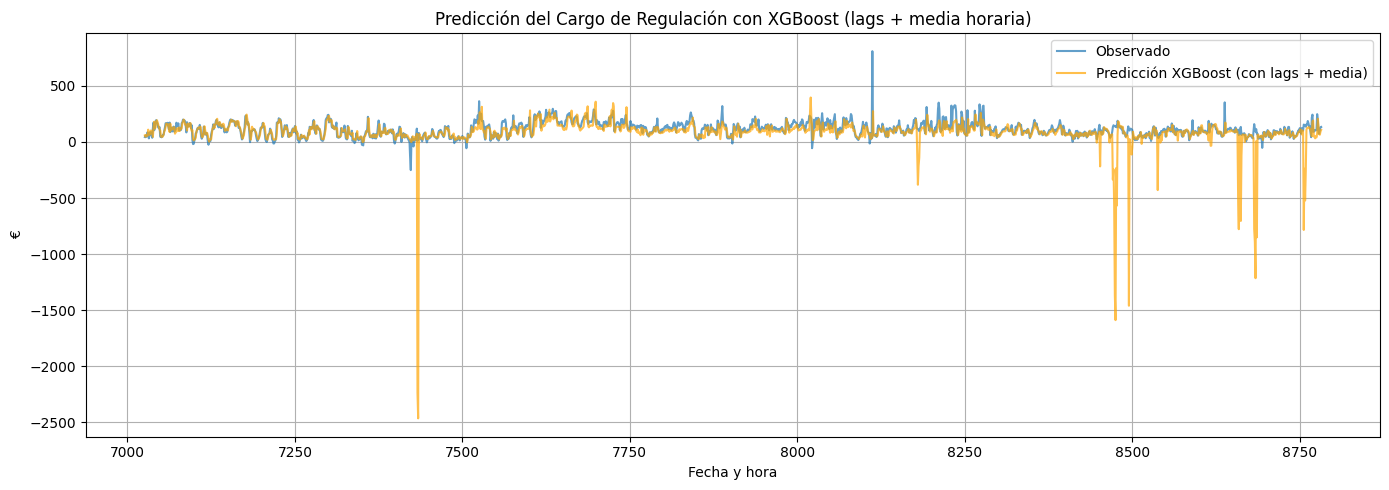

(46.015265550480244, np.float64(138.41997065016693))

In [ ]:
# Crear DataFrame base
df_modelo = df.copy()

# Añadir lags más útiles según el análisis
df_modelo["Solar_t"] = df_modelo["Solar"]
df_modelo["Solar_t-1"] = df_modelo["Solar"].shift(1)
df_modelo["Solar_t-2"] = df_modelo["Solar"].shift(2)
df_modelo["Wind_t"] = df_modelo["Wind"]
df_modelo["Wind_t-1"] = df_modelo["Wind"].shift(1)
df_modelo["Imports_t"] = df_modelo["Imports"]
df_modelo["Imports_t-1"] = df_modelo["Imports"].shift(1)
df_modelo["Hydro_t-1"] = df_modelo["Hydro"].shift(1)
df_modelo["pool"] = df_modelo["pool"]
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(1)


# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = df["media_cargo_por_hora"]

# Eliminar filas con NaNs generados por los lags
df_modelo = df_modelo.dropna()

# Variables predictoras y target
X = df_modelo[["Solar_t", "Solar_t-1","Solar_t-2", "Wind_t","Wind_t-1","Imports_t", "Imports_t-1", "pool",
               "Hydro_t-1", "Hydro", "cargo de regulacion_t-1", "media_cargo_por_hora", "desviacion total"]]
#X = df_modelo.drop(columns=["cargo de regulación", "Fecha_Prev", "AÑO"])  # features
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo RF
modelo_rf2 = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    random_state=42
)
modelo_rf2.fit(X_train, y_train)
y_pred = modelo_rf2.predict(X_test)

# Evaluación
mae7 = mean_absolute_error(y_test, y_pred)
rmse7 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae7, rmse7


<ipython-input-324-df74631d8443>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




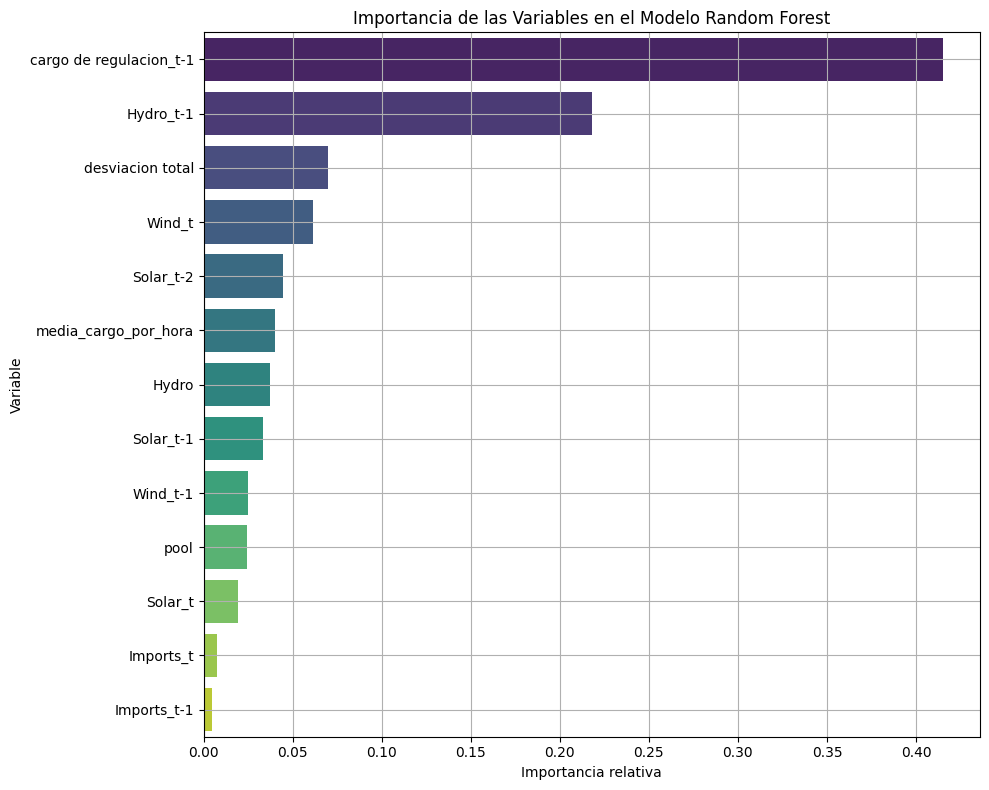

In [ ]:
# Extraer la importancia de cada variable
importancias = modelo_rf2.feature_importances_
nombres_columnas = X_train.columns

# Crear DataFrame con resultados
df_importancia = pd.DataFrame({
    'Variable': nombres_columnas,
    'Importancia': importancias
}).sort_values(by="Importancia", ascending=False)

# Visualización
plt.figure(figsize=(10, 8))
sns.barplot(x="Importancia", y="Variable", data=df_importancia.head(20), palette="viridis")
plt.title("Importancia de las Variables en el Modelo Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.grid(True)
plt.show()


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Hydro_t-1
- Imports_t
- Imports_t-1
- Solar_t
- Solar_t-1
- ...
Feature names seen at fit time, yet now missing:
- AÑO
- Battery Consumption
- Battery Injection
- Biomass
- Consumption
- ...


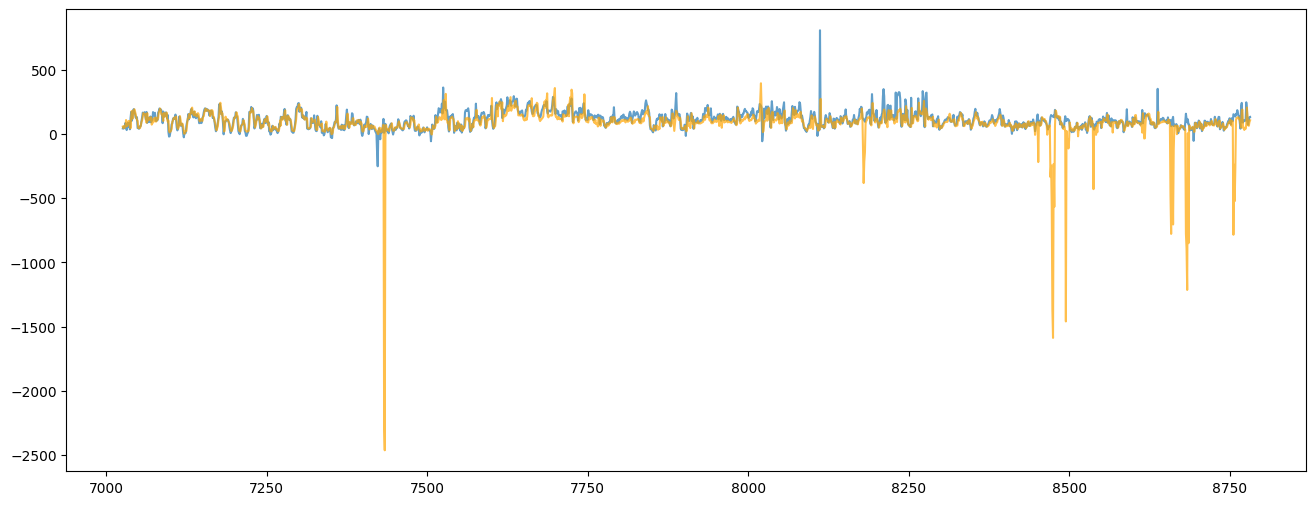

In [ ]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_rf.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = range(last_index + 1, last_index + 1 + 168)

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

##MODELO3RF

In [ ]:
# Crear DataFrame base
df_modelo = df.copy()

# Añadir lags más útiles según el análisis
df_modelo["Other Thermal_t-1"] = df_modelo["Other Thermal"].shift(1)
df_modelo["Natural Gas - Cogeneration_t-1"] = df_modelo["Natural Gas - Cogeneration"].shift(1)
df_modelo["Natural Gas - Combined Cycle_t-1"] = df_modelo["Natural Gas - Combined Cycle"].shift(1)
df_modelo["Hydro_t-1"] = df_modelo["Hydro"].shift(1)
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(1)
df_modelo["Exports_t-1"] = df_modelo["Exports"].shift(1)
df_modelo["Pumping_t-1"] = df_modelo["Pumping"].shift(1)


# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = df["media_cargo_por_hora"]

# Eliminar filas con NaNs generados por los lags
df_modelo = df_modelo.dropna()

# Variables predictoras y target
X = df_modelo[["Other Thermal", "Other Thermal_t-1","Exports","Exports_t-1", "Natural Gas - Cogeneration","Natural Gas - Cogeneration_t-1",
               "Natural Gas - Combined Cycle", "Natural Gas - Combined Cycle_t-1", "pool", "Hydro_t-1", "Hydro", "cargo de regulacion_t-1",
               "media_cargo_por_hora", "Pumping"]]
#X = df_modelo.drop(columns=["cargo de regulación", "Fecha_Prev", "AÑO"])  # features
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo RF
modelo_rf3 = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    random_state=42
)
modelo_rf3.fit(X_train, y_train)
y_pred = modelo_rf3.predict(X_test)

# Evaluación
mae8 = mean_absolute_error(y_test, y_pred)
rmse8 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae8, rmse8


In [ ]:
# Extraer la importancia de cada variable
importancias = modelo_rf3.feature_importances_
nombres_columnas = X_train.columns

# Crear DataFrame con resultados
df_importancia = pd.DataFrame({
    'Variable': nombres_columnas,
    'Importancia': importancias
}).sort_values(by="Importancia", ascending=False)

# Visualización
plt.figure(figsize=(10, 8))
sns.barplot(x="Importancia", y="Variable", data=df_importancia.head(20), palette="viridis")
plt.title("Importancia de las Variables en el Modelo Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_rf3.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = range(last_index + 1, last_index + 1 + 168)

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

##MODELO4RF

In [ ]:
# Crear DataFrame base
df_modelo = df.copy()

# Añadir lags más útiles según el análisis
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(1)
df_modelo["cargo de regulacion_t-2"] = df_modelo["cargo de regulación"].shift(2)
df_modelo["cargo de regulacion_t-3"] = df_modelo["cargo de regulación"].shift(3)
df_modelo["cargo de regulacion_t-4"] = df_modelo["cargo de regulación"].shift(4)
df_modelo["cargo de regulacion_t-5"] = df_modelo["cargo de regulación"].shift(5)
df_modelo["Hydro_t-1"] = df_modelo["Hydro"].shift(1)
df_modelo["Hydro_t-2"] = df_modelo["Hydro"].shift(2)
df_modelo["Hydro_t-3"] = df_modelo["Hydro"].shift(3)
df_modelo["Solar_t-1"] = df_modelo["Solar"].shift(1)
df_modelo["Solar_t-2"] = df_modelo["Solar"].shift(2)
df_modelo["Solar_t-3"] = df_modelo["Solar"].shift(3)
df_modelo["Pumping_t-1"] = df_modelo["Pumping"].shift(1)
df_modelo["Pumping_t-2"] = df_modelo["Pumping"].shift(2)
df_modelo["Pumping_t-3"] = df_modelo["Pumping"].shift(3)
df_modelo["Pumping_t-4"] = df_modelo["Pumping"].shift(4)
df_modelo["media_cargo_por_hora_t-1"] = df_modelo["media_cargo_por_hora"].shift(1)



# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = df["media_cargo_por_hora"]

# Eliminar filas con NaNs generados por los lags
df_modelo = df_modelo.dropna()

# Variables predictoras y target
X = df_modelo[["cargo de regulacion_t-1","cargo de regulacion_t-2", "cargo de regulacion_t-3", "cargo de regulacion_t-4", "cargo de regulacion_t-5", "Hydro",
                "Hydro_t-1","Hydro_t-2", "Hydro_t-3", "Solar","Solar_t-1", "Solar_t-2", "Solar_t-3", "media_cargo_por_hora", "media_cargo_por_hora_t-1"]]
#X = df_modelo.drop(columns=["cargo de regulación", "Fecha_Prev", "AÑO"])  # features
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo RF
modelo_rf4 = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    random_state=42
)
modelo_rf4.fit(X_train, y_train)
y_pred = modelo_rf4.predict(X_test)

# Evaluación
mae9 = mean_absolute_error(y_test, y_pred)
rmse9 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae9, rmse9

In [ ]:
# Extraer la importancia de cada variable
importancias = modelo_rf4.feature_importances_
nombres_columnas = X_train.columns

# Crear DataFrame con resultados
df_importancia = pd.DataFrame({
    'Variable': nombres_columnas,
    'Importancia': importancias
}).sort_values(by="Importancia", ascending=False)

# Visualización
plt.figure(figsize=(10, 8))
sns.barplot(x="Importancia", y="Variable", data=df_importancia.head(20), palette="viridis")
plt.title("Importancia de las Variables en el Modelo Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_rf4.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = range(last_index + 1, last_index + 1 + 168)

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

##MODELO5RF

In [ ]:
# Crear DataFrame base
df_modelo = df.copy()

# Añadir lags más útiles según el análisis
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(1)
df_modelo["cargo de regulacion_t-2"] = df_modelo["cargo de regulación"].shift(2)
df_modelo["cargo de regulacion_t-3"] = df_modelo["cargo de regulación"].shift(3)
df_modelo["cargo de regulacion_t-4"] = df_modelo["cargo de regulación"].shift(4)

df_modelo["lag_23"] = df_modelo["cargo de regulación"].shift(23)
df_modelo["lag_24"] = df_modelo["cargo de regulación"].shift(24)

df_modelo["Solar_t-1"] = df_modelo["Solar"].shift(1)
df_modelo["Solar_t-2"] = df_modelo["Solar"].shift(2)
df_modelo["Solar_t-3"] = df_modelo["Solar"].shift(3)

df_modelo["media_cargo_por_hora_t-1"] = df_modelo["media_cargo_por_hora"].shift(1)



# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = df["media_cargo_por_hora"]

# Eliminar filas con NaNs generados por los lags
df_modelo = df_modelo.dropna()

# Variables predictoras y target
X = df_modelo[["cargo de regulacion_t-1","cargo de regulacion_t-2", "cargo de regulacion_t-3", "cargo de regulacion_t-4","Hydro",
               "Solar", "media_cargo_por_hora", "media_cargo_por_hora_t-1"]]
#X = df_modelo.drop(columns=["cargo de regulación", "Fecha_Prev", "AÑO"])  # features
y = df_modelo["cargo de regulación"]

# División temporal: 80% entrenamiento, 20% test
split_index = int(len(df_modelo) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Entrenar modelo RF
modelo_rf5 = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    random_state=42
)
modelo_rf5.fit(X_train, y_train)
y_pred = modelo_rf5.predict(X_test)

# Evaluación
mae9 = mean_absolute_error(y_test, y_pred)
rmse9 = np.sqrt(mean_squared_error(y_test, y_pred))

# Visualización
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Observado", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicción XGBoost (con lags + media)", color="orange", alpha=0.7)
plt.title("Predicción del Cargo de Regulación con XGBoost (lags + media horaria)")
plt.xlabel("Fecha y hora")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae9, rmse9

In [ ]:
# Extraer la importancia de cada variable
importancias = modelo_rf5.feature_importances_
nombres_columnas = X_train.columns

# Crear DataFrame con resultados
df_importancia = pd.DataFrame({
    'Variable': nombres_columnas,
    'Importancia': importancias
}).sort_values(by="Importancia", ascending=False)

# Visualización
plt.figure(figsize=(10, 8))
sns.barplot(x="Importancia", y="Variable", data=df_importancia.head(20), palette="viridis")
plt.title("Importancia de las Variables en el Modelo Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# Crear una figura combinada con test histórico + semana futura
fig, ax = plt.subplots(figsize=(16, 6))

# 1. Parte histórica: y_test vs predicción
ax.plot(y_test.index, y_test, label="Observado", alpha=0.7)
ax.plot(y_test.index, y_pred, label="Predicción XGBoost", color="orange", alpha=0.7)

# 2. Parte futura: predicción con intervalo
residuos = y_test - y_pred
std_error = residuos.std()

X_future = X_test.tail(168).copy()
y_future_pred = modelo_rf5.predict(X_future)
last_index = y_test.index[-1]

# Crear índice extendido para la semana futura
future_index = range(last_index + 1, last_index + 1 + 168)

# Agregar al gráfico
ax.plot(future_index, y_future_pred, label="Predicción futura", color="red")
ax.fill_between(future_index,
                y_future_pred - 1.96 * std_error,
                y_future_pred + 1.96 * std_error,
                color="red", alpha=0.2, label="IC 95%")

# Etiquetas y leyenda
ax.set_title("Predicción del Cargo de Regulación: Observado, Actual y Futura")
ax.set_xlabel("Índice de tiempo")
ax.set_ylabel("€")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

#CNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Crear DataFrame base
df_modelo = df.copy()

# Añadir lags más útiles según el análisis
df_modelo["Solar_t"] = df_modelo["Solar"]
df_modelo["Solar_t-1"] = df_modelo["Solar"].shift(1)
df_modelo["Solar_t-2"] = df_modelo["Solar"].shift(2)
df_modelo["Wind_t"] = df_modelo["Wind"]
df_modelo["Wind_t-1"] = df_modelo["Wind"].shift(1)
df_modelo["Imports_t"] = df_modelo["Imports"]
df_modelo["Imports_t-1"] = df_modelo["Imports"].shift(1)
df_modelo["Hydro_t-1"] = df_modelo["Hydro"].shift(1)
df_modelo["pool"] = df_modelo["pool"]
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(1)


# Añadir la media histórica por hora
df_modelo["media_cargo_por_hora"] = df["media_cargo_por_hora"]

# Eliminar filas con NaNs generados por los lags
df_modelo = df_modelo.dropna()

# Variables predictoras y target
X = df_modelo[["Solar_t", "Solar_t-1","Solar_t-2", "Wind_t","Wind_t-1","Imports_t", "Imports_t-1", "pool",
               "Hydro_t-1", "Hydro", "cargo de regulacion_t-1", "media_cargo_por_hora", "desviacion total"]]
#X = df_modelo.drop(columns=["cargo de regulación", "Fecha_Prev", "AÑO"])  # features
y = df_modelo["cargo de regulación"]

# Forzar a numérico, reemplazando errores con NaN y luego eliminándolos
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

y = pd.to_numeric(y, errors='coerce')

# Eliminar filas con valores faltantes (por conversiones fallidas)
X = X.dropna()
y = y[X.index]  # Asegurar sincronía

# Seleccionar columnas relevantes
features = X # Puedes agregar más: ['pool', 'wind', 'solar', 'biomasa', ...]
target = y

# Normalización
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(features)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Crear secuencias para la red LSTM
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Crear el modelo CNN + LSTM
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(time_steps, X_seq.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=1)

# Evaluación
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predicciones
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# Comparar
import matplotlib.pyplot as plt
plt.plot(y_true[:200], label='Real')
plt.plot(y_pred[:200], label='Predicho')
plt.legend()
plt.title("Comparación de valores reales y predichos")
plt.show()


In [ ]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.2f}")

#LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === PREPROCESADO ===

# Suponiendo que df ya está cargado
df_modelo = df.copy()
df_modelo["Solar_t"] = df_modelo["Solar"]
df_modelo["Solar_t-1"] = df_modelo["Solar"].shift(1)
df_modelo["Solar_t-2"] = df_modelo["Solar"].shift(2)
df_modelo["Wind_t"] = df_modelo["Wind"]
df_modelo["Wind_t-1"] = df_modelo["Wind"].shift(1)
df_modelo["Imports_t"] = df_modelo["Imports"]
df_modelo["Imports_t-1"] = df_modelo["Imports"].shift(1)
df_modelo["Hydro_t-1"] = df_modelo["Hydro"].shift(1)
df_modelo["pool"] = df_modelo["pool"]
df_modelo["cargo de regulacion_t-1"] = df_modelo["cargo de regulación"].shift(1)
df_modelo["media_cargo_por_hora"] = df["media_cargo_por_hora"]

df_modelo = df_modelo.dropna()

X = df_modelo[["Solar_t", "Solar_t-1", "Solar_t-2", "Wind_t", "Wind_t-1", "Imports_t", "Imports_t-1",
               "pool", "Hydro_t-1", "Hydro", "cargo de regulacion_t-1", "media_cargo_por_hora", "desviacion total"]]
y = df_modelo["cargo de regulación"]

# Convertir a numérico
X = X.copy()
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
y = pd.to_numeric(y, errors='coerce')

X = X.dropna()
y = y[X.index]

# Normalizar
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# === CREACIÓN DE SECUENCIAS ===

def create_sequences(X, y, time_steps=48):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps=48)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# === MODELO LSTM ===

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss=Huber(delta=100))

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

# === EVALUACIÓN ===
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.2f}")

# === VISUALIZACIÓN ===
plt.figure(figsize=(10, 5))
plt.plot(y_true[:200], label='Real')
plt.plot(y_pred[:200], label='Predicho')
plt.title("Predicción del cargo de regulación (solo LSTM)")
plt.xlabel("Muestras")
plt.ylabel("€")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
